# LSTM Attempt

In [ ]:
# !pip install pandas
# !pip install transformers
# !pip install nltk
# !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 torchtext==0.16.2 --index-url https://download.pytorch.org/whl/cu118
# !pip install torchmetrics
# !pip install spacy
# !pip install matplotlib
# !pip install scikit-learn
# !pip install torchmetrics
# !pip install imbalanced-learn
# !pip install torcheval

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
import nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizerFast, BertModel, BertTokenizer
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torcheval.metrics import BinaryF1Score
import torcheval.metrics.classification
from torcheval.metrics.classification import BinaryRecall
from torcheval.metrics import BinaryAUPRC
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy
from torch.nn.utils.rnn import pad_sequence
# from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator, Vocab
from collections import Counter
from sklearn.metrics import mean_squared_error
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from sklearn.metrics import accuracy_score
import imblearn
from sklearn.metrics import precision_recall_fscore_support
import torcheval.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


torch.cuda.is_available()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
!export CUBLAS_WORKSPACE_CONFIG=:16:8
!export CUBLAS_WORKSPACE_CONFIG=:4096:2

# For 1st model

# data preprocessing

1) remove stopwords
2) add 1 or 0
3) merge


In [4]:
with open('./Data/fake.pkl', 'rb') as f:
    fake_pkl = pickle.load(f)

with open('./Data/real.pkl', 'rb') as file:
    real_pkl = pickle.load(file)

# print(f'Fake pickle file:\n{fake_pkl[0:5]}\n')
# print(f'Real pickle file:\n{real_pkl[0:5]}\n')

adding "[CLS] " and " [SEP]" at the start and end of every row as bert tokenizer works that way

In [5]:
def remove_stopwords(sentence, stop_words):
    word_tokens = word_tokenize(sentence)
    filtered = " ".join([i.lower() for i in word_tokens if not i.lower() in stop_words])
    return filtered


fake_df = pd.DataFrame(fake_pkl, columns=["original"])
real_df = pd.DataFrame(real_pkl, columns=["original"])

print(f'Fake Dataframe:\n{fake_df[0:5]}\n')
print(f'Real Dataframe:\n{real_df[0:5]}\n')

stop_words = set(stopwords.words('english'))

result = [remove_stopwords(x, stop_words) for x in fake_df['original']]
fake = pd.DataFrame(result, columns=["cleaned"])
result = [remove_stopwords(x, stop_words) for x in real_df['original']]
real = pd.DataFrame(result, columns=["cleaned"])

print(f'Fake Dataframe:\n{fake[0:5]}\n')
print(f'Real Dataframe:\n{real[0:5]}\n')


Fake Dataframe:
                                            original
0  In todays of reports on a fake Proof of Life J...
1  On the people will have the opportunity to do ...
2  J This is the continuation of the testimony I ...
3  The great thing about modern technology and fo...
4  on Longtime If All of s s She Could Lose State...

Real Dataframe:
                                            original
0  Ward was convicted of arson in He was given an...
1  At vast global gatherings like the climate whi...
2  had decided to release Life on Mars as a singl...
3  In a land of the grammar is king I should know...
4  In came under fire for suggesting that half of...

Fake Dataframe:
                                             cleaned
0  todays reports fake proof life jump trump saw ...
1  people opportunity department justice refuse d...
2  j continuation testimony present public utilit...
3  great thing modern technology food industriali...
4  longtime could lose states new read emails wou

In [6]:
def add_label(dataset, label):
    dataset['label'] = label
    return dataset

real_labeled = add_label(real, 0)
fake_labeled = add_label(fake, 1)
print(real_labeled.columns, real_labeled[0:2], len(real_labeled))
print(fake_labeled.columns, fake_labeled[0:2], len(fake_labeled))

combined_labeled = pd.concat([real_labeled, fake_labeled])
print(combined_labeled.columns, combined_labeled[0:2], len(combined_labeled))



Index(['cleaned', 'label'], dtype='object')                                              cleaned  label
0  ward convicted arson given indeterminate sente...      0
1  vast global gatherings like climate concluded ...      0 9762
Index(['cleaned', 'label'], dtype='object')                                              cleaned  label
0  todays reports fake proof life jump trump saw ...      1
1  people opportunity department justice refuse d...      1 12228
Index(['cleaned', 'label'], dtype='object')                                              cleaned  label
0  ward convicted arson given indeterminate sente...      0
1  vast global gatherings like climate concluded ...      0 21990


## Embedding: GLove

In [7]:
spacy_tinputs = []
tokenizer = get_tokenizer("basic_english")

unique_tokens = []
max_length = 0

# tokenise the sentences, output []
for sent in combined_labeled['cleaned']:
    tokens = tokenizer(sent)
    for i in tokens:
        if i not in unique_tokens:
            unique_tokens.append(i)

    spacy_tinputs.append(tokens)
    if len(tokens) > max_length:
        # print(len(tokens))
        max_length = len(tokens)

In [8]:
print(len(unique_tokens), max_length)
# print(len(spacy_tinputs), max_length)
# needs padding
print(len(spacy_tinputs[1]), len(spacy_tinputs[0]))


56373 3794
372 260


In [9]:
# Load pre-trained GloVe embeddings
glove = GloVe(name='6B', dim=100)

class NewsArticleDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.label[idx]
        # Convert text to numerical vectors using pre-trained word embeddings (GloVe)
        vectorized_text = [glove[word] for word in text if word in glove.stoi]
        if not vectorized_text:
            vectorized_text = [torch.zeros(100)]  # Use zero vector if no valid embeddings are found
        return torch.stack(vectorized_text), label

dataset = NewsArticleDataset(spacy_tinputs, combined_labeled['label'].values)

In [10]:
batch_size = 40
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed= 42



# vocab_list = create_vocab()

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices, val_indices = indices[2*split:], indices[:split], indices[split:split*2]

print(len(train_indices))

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.tensor(labels)


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler, collate_fn=collate_fn ,drop_last=True)

validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, collate_fn= collate_fn, drop_last=True)

# test does not need batch size
test_loader = DataLoader(dataset, batch_size=1, sampler=test_sampler)

21990
17592


In [11]:
len(train_loader)

439

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [13]:
#
i = 0
for batch in train_loader:
    if i:
        a,b = batch
        print(a.shape, b.shape)
        break
    i+=1

torch.Size([40, 1698, 100]) torch.Size([40])


## LSTM Model

In [90]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, num_classes, num_layers, vocab_size, embedding_dim, dropout):
        super(LSTMModel, self).__init__()
        # self.embedding = nn.Embedding(num_embeddings=vocab_size, \
        #                                embedding_dim= embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,\
                            num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        # loss
        self.loss = nn.BCELoss()
        self.sigmoid = nn.Sigmoid()

        # self.relu = nn.relu()
        self.accuracy = BinaryAccuracy()


    def forward(self, inputs):
        # embed_inputs = self.embedding(inputs)
        # print("Embed inputs: ", embed_inputs.shape)
        out, (hidden, cell) = self.lstm(inputs)

        hidden = hidden[-1]
        out = self.relu(hidden)
        out1 = self.fc_1(out)
        out2 = self.relu(out1)
        out3 = self.fc(out2)
        # out4 = self.sigmoid(out3)
        out4 = self.relu(out3)
        return out4

    def binary_f1_score(self, y_pred, y_true):
        y_true = y_true.float()
        y_pred = (y_pred > 0.5).float()

        tp = (y_true * y_pred).sum().item()
        fp = ((1 - y_true) * y_pred).sum().item()
        fn = (y_true * (1 - y_pred)).sum().item()

        epsilon = 1e-7
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        return f1

    def binary_recall(self, y_pred, y_true):
        y_true = y_true.float()
        y_pred = (y_pred > 0.5).float()

        tp = (y_true * y_pred).sum().item()
        fn = (y_true * (1 - y_pred)).sum().item()

        epsilon = 1e-7
        recall = tp / (tp + fn + epsilon)
        return recall

    def binary_precision(self, y_pred, y_true):
        y_true = y_true.float()
        y_pred = (y_pred > 0.5).float()

        tp = (y_true * y_pred).sum().item()
        fp = ((1 - y_true) * y_pred).sum().item()

        epsilon = 1e-7
        precision = tp / (tp + fp + epsilon)
        return precision

In [91]:
# input_size = 1 # number of features
hidden_size = 64
num_classes = 1
num_layers = 2
embedding_dim = 100
dropout = 0.2
vocab_size = len(unique_tokens)
lstm_model = LSTMModel(hidden_size, num_classes, num_layers, vocab_size, embedding_dim, dropout).to(device)

In [92]:
print(lstm_model)

LSTMModel(
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (loss): BCELoss()
  (sigmoid): Sigmoid()
  (accuracy): BinaryAccuracy()
)


In [93]:
learning_rate = 0.001
num_epochs = 3
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(lstm_model.parameters(), lr=learning_rate)

 33%|███▎      | 1/3 [01:11<02:23, 71.90s/it]

Test loss: 0.6824, Test Accuracy: 1.0000
Test Precision: 0.0000, Test F1: 0.0000, Test recall: 0.0000
Saving best model with test loss: 0.6824
Epoch [1/3], Training loss: 0.7081, Training Accuracy: 0.5000
Training Precision: 0.5000, Training F1: 0.6667, Training recall: 1.0000


 67%|██████▋   | 2/3 [02:09<01:03, 63.70s/it]

Test loss: 0.6864, Test Accuracy: 0.0000
Test Precision: 0.0000, Test F1: 0.0000, Test recall: 0.0000
Epoch [2/3], Training loss: 0.6304, Training Accuracy: 0.7000
Training Precision: 0.7000, Training F1: 0.7778, Training recall: 0.8750


100%|██████████| 3/3 [03:12<00:00, 64.07s/it]

Test loss: 0.7166, Test Accuracy: 0.0000
Test Precision: 0.0000, Test F1: 0.0000, Test recall: 0.0000
Epoch [3/3], Training loss: 0.7249, Training Accuracy: 0.5500
Training Precision: 0.5000, Training F1: 0.6250, Training recall: 0.8333


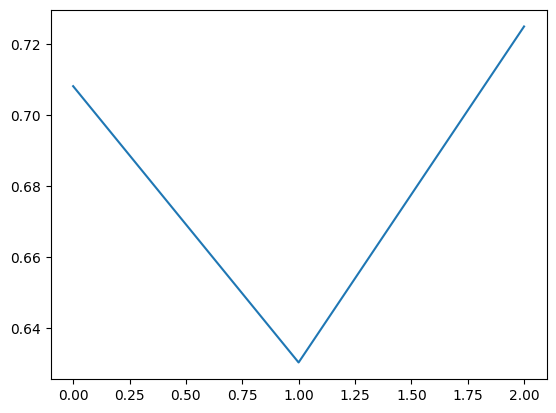

In [94]:
test_loss_list = []
loss_list = []
epoch_list = []

def train(train_loader, test_loader):
    best_loss = 100

    for epoch in tqdm(range(num_epochs)):
        y_true = []
        y_pred = []
        lstm_model.train()
        for batch in train_loader:

            optimizer.zero_grad()
            # print(batch)
            texts, labels = batch
            texts = texts.to(device)
            labels = labels.to(device)


            # forward pass
            outputs = lstm_model.forward(texts)
            labels =labels.to(torch.float)

            labels = labels.reshape(-1, 1)

            # loss
            loss = lstm_model.loss(outputs, labels)
            binary_acc = lstm_model.accuracy(outputs, labels)
            binary_pre = lstm_model.binary_precision(outputs, labels)
            binary_f1 = lstm_model.binary_f1_score(outputs, labels)
            binary_rec = lstm_model.binary_recall(outputs, labels)

            # back prop
            loss.backward()
            optimizer.step()

        test_loss = evaluate(test_loader)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_weights = lstm_model.state_dict()
            torch.save(best_model_weights, 'glove_adam_model_1.pt')
            print(f'Saving best model with test loss: {best_loss:.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Training loss: {loss.item():.4f}, Training Accuracy: {binary_acc:.4f}')
        print(f'Training Precision: {binary_pre:.4f}, Training F1: {binary_f1:.4f}, Training recall: {binary_rec:.4f}')
        loss_list.append(loss.item())

def evaluate(loader):
    test_loss_list = []
    y_true = []
    y_pred = []
    lstm_model.eval()
    for batch in loader:

        with torch.no_grad():
            # print(batch)
            texts, labels = batch
            texts = texts.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = lstm_model.forward(texts)

            labels =labels.to(torch.float)
            # print(labels.shape)
            labels = labels.reshape(-1, 1)
            # loss
            loss = lstm_model.loss(outputs, labels)
            binary_acc = lstm_model.accuracy(outputs, labels)
            binary_pre = lstm_model.binary_precision(outputs, labels)
            binary_f1 = lstm_model.binary_f1_score(outputs, labels)
            binary_rec = lstm_model.binary_recall(outputs, labels)

            test_loss_list.append(loss)

    avg_loss = sum(test_loss_list) / len(loader)
    print(f'Test loss: {avg_loss.item():.4f}, Test Accuracy: {binary_acc:.4f}')
    print(f'Test Precision: {binary_pre:.4f}, Test F1: {binary_f1:.4f}, Test recall: {binary_rec:.4f}')

    return avg_loss

train(train_loader, test_loader)
epoch_list = [i for i in range(len(loss_list))]
plt.plot(epoch_list, loss_list)
plt.show()

# Second model for classification

In [3]:
def read_and_drop_data(path):
    data =  pd.read_csv(path)
    data = data.drop(data[data['label'] == 'Real'].index)
    columns = ['author', 'published', 'title', 'text', 'language', 'site_url', 'main_img_url',
               'label', 'hasImage', 'title_without_stopwords']
    data = data.drop(columns=columns, axis=1)
    data.dropna(inplace=True)

    return data

path = './Data/news_articles.csv'
second_dataset = read_and_drop_data(path)

In [4]:
print(second_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1292 entries, 33 to 1992
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   type                    1292 non-null   object
 1   text_without_stopwords  1292 non-null   object
dtypes: object(2)
memory usage: 30.3+ KB
None


In [5]:
second_dataset["type"] = second_dataset["type"].map({"bias": 0, "conspiracy": 1, "fake": 2, "hate": 3, "bs": 4, "satire": 5, "junksci": 6})
second_dataset.dropna(inplace=True)
print(second_dataset.head())

    type                             text_without_stopwords
33     1  st century wire says wire reported friday fbis...
34     1  stunning turn events days presidential electio...
35     1  tidal wave revelations pouring clinton campaig...
36     1  november wire comments patrick henningsen st c...
37     1  november shawn helton comment shawn helton st ...


In [6]:
second_dataset.groupby("type").size().sort_values(ascending=True)

type
2     15
6    102
5    146
1    430
4    599
dtype: int64

In [7]:
second_dataset = second_dataset.reset_index()
print(second_dataset.head())

   index  type                             text_without_stopwords
0     33     1  st century wire says wire reported friday fbis...
1     34     1  stunning turn events days presidential electio...
2     35     1  tidal wave revelations pouring clinton campaig...
3     36     1  november wire comments patrick henningsen st c...
4     37     1  november shawn helton comment shawn helton st ...


In [8]:
from sklearn.preprocessing import LabelEncoder

for index, row in second_dataset.iterrows():
    count = second_dataset.groupby("type").size().sort_values(ascending=True)[4]
    count1 = second_dataset.groupby("type").size().sort_values(ascending=True)[1]
    if count > 400 and row['type'] == 4:
        second_dataset.drop(index, inplace=True)
    elif count1 > 400 and row['type'] == 1:
        second_dataset.drop(index, inplace=True)

second_dataset.drop('index', inplace=True, axis=1)
second_dataset["type"] = second_dataset["type"].map({1: 0, 2: 1, 4: 2, 5: 3, 6: 4})
df_ohe = pd.get_dummies(second_dataset['type'])
second_dataset = pd.concat([second_dataset[['text_without_stopwords']], df_ohe], axis=1)

print(second_dataset.head(), second_dataset.info())
# second_dataset.groupby("type").size().sort_values(ascending=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1063 entries, 24 to 1291
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text_without_stopwords  1063 non-null   object
 1   0                       1063 non-null   bool  
 2   1                       1063 non-null   bool  
 3   2                       1063 non-null   bool  
 4   3                       1063 non-null   bool  
 5   4                       1063 non-null   bool  
dtypes: bool(5), object(1)
memory usage: 21.8+ KB
                                text_without_stopwords      0      1      2  \
24   share president obama signed executive order d...  False   True  False   
25   united states marine field mcconnell plum city...  False   True  False   
167  melissa dykes oligarchy runs society problem r...   True  False  False   
168  jay syrmopoulos pipeline opponents attempting ...   True  False  False   
169  learn liberty anonymity shield t

After removing some of the rows that cause a severe class imbalance

In [9]:
spacy_tinputs = []
tokenizer = get_tokenizer("basic_english")
# tokenizer = en_core_web_sm.load()
unique_tokens = []
max_length = 0

# tokenise the sentences, output []
for sent in second_dataset['text_without_stopwords']:
    tokens = tokenizer(sent)
    for i in tokens:
        if i not in unique_tokens:
            unique_tokens.append(i)

    spacy_tinputs.append(tokens)
    if len(tokens) > max_length:
        # print(len(tokens))
        max_length = len(tokens)

In [10]:
print(len(unique_tokens), max_length)


33506 2981


In [11]:
second_dataset.head()

,text_without_stopwords,0,1,2,3,4
24,share president obama signed executive order d...,False,True,False,False,False
25,united states marine field mcconnell plum city...,False,True,False,False,False
167,melissa dykes oligarchy runs society problem r...,True,False,False,False,False
168,jay syrmopoulos pipeline opponents attempting ...,True,False,False,False,False
169,learn liberty anonymity shield tyranny majorit...,True,False,False,False,False


## GLove embedding

In [13]:
# Load pre-trained GloVe embeddings
glove = GloVe(name='6B', dim=100)

class NewsArticleDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label
        self.max_length = 22565

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.label[idx]
        # Convert text to numerical vectors using pre-trained word embeddings (GloVe)
        vectorized_text = [glove[word] for word in text if word in glove.stoi]
        # if not vectorized_text:
        #     vectorized_text = [torch.zeros(100)]  # Use zero vector if no valid embeddings are found
        # return torch.stack(vectorized_text), torch.tensor(label, dtype=torch.float)
        if len(vectorized_text) < self.max_length:
            # Pad the vectorized text if it is shorter than the maximum length
            padding = [torch.zeros(100)] * (self.max_length - len(vectorized_text))
            vectorized_text.extend(padding)

        return torch.stack(vectorized_text), torch.tensor(label, dtype=torch.float)


dataset = NewsArticleDataset(spacy_tinputs, second_dataset.iloc[:, -5:].values)
# dataset = NewsArticleDataset(spacy_tinputs, label_y.values)
# print(dataset.shape)

In [14]:
batch_size = 32
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed= 42



# vocab_list = create_vocab()

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices, val_indices = indices[2*split:], indices[:split], indices[split:split*2]

print(len(train_indices))

def collate_fn(batch):
    # print(len(batch), batch[1].shape)
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, labels


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler, collate_fn=collate_fn ,drop_last=True)

validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, collate_fn= collate_fn, drop_last=True)

test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

1063
851


In [15]:
len(train_loader)

26

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


## 2nd Model

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, num_layers, vocab_size, embedding_dim, dropout, num_classes=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, num_classes)  # Update output size to match the number of classes
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

        # Use CrossEntropyLoss for multi-class classification
        self.loss = nn.CrossEntropyLoss() # Use Accuracy metric for multi-class classification
        self.accuracy = MulticlassAccuracy(num_classes)

    def forward(self, inputs):
        out, (hidden, cell) = self.lstm(inputs)
        hidden = hidden[-1]
        out = self.relu(hidden)
        # out = self.sigmoid(hidden)
        out1 = self.fc_1(out)
        out2 = self.relu(out1)
        out3 = self.fc(out2)
        return out3

    def accuracy(self, outputs, labels):
        # Convert predicted probabilities to predicted class labels
        _, predicted_labels = torch.max(outputs, dim=1)

        # Convert tensors to numpy arrays
        predicted_labels = predicted_labels.cpu().numpy()
        labels = labels.cpu().numpy()

        # Convert one-hot encoded labels to class labels
        true_labels = np.argmax(labels, axis=1)

        # Compute accuracy
        acc = accuracy_score(true_labels, predicted_labels)
        return acc

    def multiclass_precision(self, y_pred, y_true):
        y_true = y_true.argmax(dim=1)  # Convert one-hot encoded labels to class indices
        y_pred = y_pred.argmax(dim=1)  # Get the predicted class indices

        precision_scores = []
        for class_idx in range(self.num_classes):
            tp = ((y_true == class_idx) & (y_pred == class_idx)).sum().item()
            fp = ((y_true != class_idx) & (y_pred == class_idx)).sum().item()

            epsilon = 1e-7
            precision = tp / (tp + fp + epsilon)
            precision_scores.append(precision)

        return sum(precision_scores) / self.num_classes

    def multiclass_recall(self, y_pred, y_true):
        y_true = y_true.argmax(dim=1)  # Convert one-hot encoded labels to class indices
        y_pred = y_pred.argmax(dim=1)  # Get the predicted class indices

        recall_scores = []
        for class_idx in range(self.num_classes):
            tp = ((y_true == class_idx) & (y_pred == class_idx)).sum().item()
            fn = ((y_true == class_idx) & (y_pred != class_idx)).sum().item()

            epsilon = 1e-7
            recall = tp / (tp + fn + epsilon)
            recall_scores.append(recall)

        return sum(recall_scores) / self.num_classes

    def multiclass_f1_score(self, y_pred, y_true):
        y_true = y_true.argmax(dim=1)  # Convert one-hot encoded labels to class indices
        y_pred = y_pred.argmax(dim=1)  # Get the predicted class indices

        f1_scores = []
        for class_idx in range(self.num_classes):
            tp = ((y_true == class_idx) & (y_pred == class_idx)).sum().item()
            fp = ((y_true != class_idx) & (y_pred == class_idx)).sum().item()
            fn = ((y_true == class_idx) & (y_pred != class_idx)).sum().item()

            epsilon = 1e-7
            precision = tp / (tp + fp + epsilon)
            recall = tp / (tp + fn + epsilon)
            f1 = 2 * (precision * recall) / (precision + recall + epsilon)
            f1_scores.append(f1)

        return sum(f1_scores) / self.num_classes

In [37]:
# input_size = 1 # number of features
hidden_size = 64
num_layers = 2
embedding_dim = 100
dropout = 0.2
num_epochs = 10
vocab_size = len(unique_tokens)
lstm_model = LSTMModel(hidden_size,num_layers, vocab_size, embedding_dim, dropout, 5).to(device)

In [35]:
print(lstm_model)

LSTMModel(
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (loss): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
)


In [36]:
learning_rate = 0.001
num_epochs = 10
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(lstm_model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 1.6399, Test Accuracy: 0.2000
Test Precision: 0.0400, Test F1: 0.0667, Test recall: 0.2000
Saving best model with test loss: 1.6399
Epoch [1/10], Training loss: 1.6241, Training Accuracy: 0.1562
Training Precision: 0.0312, Training F1: 0.0541, Training recall: 0.2000
Test loss: 1.6478, Test Accuracy: 0.1000
Test Precision: 0.0200, Test F1: 0.0364, Test recall: 0.2000
Epoch [2/10], Training loss: 1.6645, Training Accuracy: 0.0312
Training Precision: 0.0062, Training F1: 0.0121, Training recall: 0.2000
Test loss: 1.6447, Test Accuracy: 0.1000
Test Precision: 0.0200, Test F1: 0.0364, Test recall: 0.2000
Epoch [3/10], Training loss: 1.6352, Training Accuracy: 0.1250
Training Precision: 0.0250, Training F1: 0.0444, Training recall: 0.2000
Test loss: 1.6414, Test Accuracy: 0.2000
Test Precision: 0.0400, Test F1: 0.0667, Test recall: 0.2000
Epoch [4/10], Training loss: 1.6417, Training Accuracy: 0.0625
Training Precision: 0.0125, Training F1: 0.0235, Training recall: 0.2000
Test lo

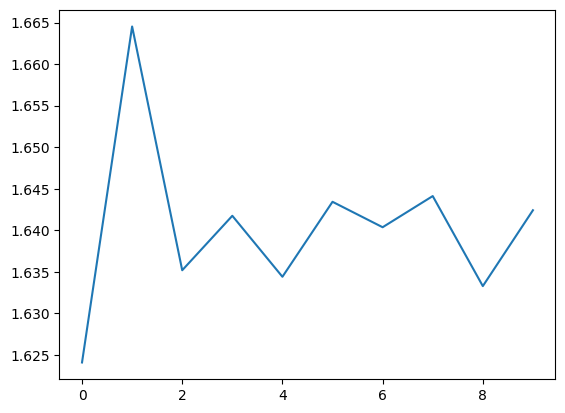

In [38]:
test_loss_list = []
loss_list = []
epoch_list = []

def train(train_loader, test_loader):
    best_loss = 100
    for epoch in tqdm(range(num_epochs)):
        lstm_model.train()
        for batch in train_loader:

            optimizer.zero_grad()
            texts, labels = batch
            labels = torch.stack(labels)
            texts = texts.to(device)
            labels = labels.to(device)


            # forward pass
            outputs = lstm_model.forward(texts).to(device)
            # print(outputs.shape)
            labels =labels.to(torch.float).to(device)

            # loss
            loss = lstm_model.loss(outputs, labels)
            binary_acc = lstm_model.accuracy(outputs, labels)
            binary_pre = lstm_model.multiclass_precision(outputs, labels)
            binary_f1 = lstm_model.multiclass_f1_score(outputs, labels)
            binary_rec = lstm_model.multiclass_recall(outputs, labels)

            # back prop
            loss.backward()
            optimizer.step()

        test_loss = evaluate(test_loader)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_weights = lstm_model.state_dict()
            torch.save(best_model_weights, 'glove_adam_model_2.pt')
            print(f'Saving best model with test loss: {best_loss:.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Training loss: {loss.item():.4f}, Training Accuracy: {binary_acc:.4f}')
        print(f'Training Precision: {binary_pre:.4f}, Training F1: {binary_f1:.4f}, Training recall: {binary_rec:.4f}')
        loss_list.append(loss.item())

def evaluate(loader):
    test_loss_list = []
    lstm_model.eval()
    for batch in loader:
        with torch.no_grad():
            # print(batch)
            texts, labels = batch
            texts = texts.to(device)

            # forward pass
            outputs = lstm_model.forward(texts).to(device)


            labels =labels.to(torch.float).to(device)
            loss = lstm_model.loss(outputs, labels)
            binary_acc = lstm_model.accuracy(outputs, labels)
            binary_pre = lstm_model.multiclass_precision(outputs, labels)
            binary_f1 = lstm_model.multiclass_f1_score(outputs, labels)
            binary_rec = lstm_model.multiclass_recall(outputs, labels)

            test_loss_list.append(loss)

    avg_loss = sum(test_loss_list) / len(loader)
    print(f'Test loss: {avg_loss.item():.4f}, Test Accuracy: {binary_acc:.4f}')
    print(f'Test Precision: {binary_pre:.4f}, Test F1: {binary_f1:.4f}, Test recall: {binary_rec:.4f}')

    return avg_loss

train(train_loader, test_loader)
epoch_list = [i for i in range(len(loss_list))]
plt.plot(epoch_list, loss_list)
plt.show()